# Nonlinear Equations

## Introduction

Nonlinear equations are ubiquitous in scientific computing. In power systems,
the AC power flow equations are nonlinear equations.

The standard form of nonlinear equations is:

$$
f(x) = 0
$$

where `f` is a nonlinear function and `x` is the variable. In other
words, solving nonlinear equations means finding the roots of a function. This
function is called the **residual** function, which will be small enough (zero
at the tolerance level) when the solution is found. 






## Residual Function

The way to represent a nonlinear equation is to define the residual function.
This is straightforward for simple problems in Python.

Consider this problem from `scipy.optimize.fsolve` documentation:

$$
x_0 \cos(x_1) = 4
$$

$$
x_1 x_0 - x_1 = 5
$$

we can define the residual function as:


In [1]:
import numpy as np


def residual(x):
    return [x[0]*np.cos(x[1]) - 4,
            x[0]*x[1] - x[1] - 5]


Note that for the function argument `x`, it is implicitly a 1D NumPy array. 

## Root-Finding with `fsolve`

One of the most common methods to solve nonlinear equations is the
[Newton-Raphson method](https://en.wikipedia.org/wiki/Newton%27s_method). In
practice, for simple problems, we can use off-the-shelf solvers in Python.

`fsolve` is a function in `scipy.optimize` for root-finding. We can check the
docstring by typing `?fsolve` in a Jupyter cell or visiting the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html).

In [2]:
from scipy.optimize import fsolve

x0 = [1, 1]
sol = fsolve(residual, x0)
print(sol)


[6.50409711 0.90841421]


In [3]:
np.isclose(residual(sol), [0.0, 0.0])  # the residual at the solution should be almost 0.0.

array([ True,  True])

### Initial Guess

Initial guess plays an important role in the solver convergence. An inproper
initial guess may result in failure to converge. Such guesses are said to be
**not in the region of attraction** of the solution.

For example, if we use the initial guess `[0, 0]`, the solver will fail to
converge.


In [4]:
sol = fsolve(residual, [0, 0])

/tmp/ipykernel_60358/2019346469.py:1: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  sol = fsolve(residual, [0, 0])


The error message indicates that the residual function did not converge to zero
in the last ten steps. 

In other cases, a different initial guess may result in a different solution.
Consider the simple equation 

$$x^2 - 1 = 0$$

Starting from `1.2` and `-1.2` will converge to `1` and `-1`, respectively.

In [5]:
def simple_residual(x):
    return [x[0]**2 - 1]

sol = fsolve(simple_residual, [1.2])
print("Starting from 1.2, the solution is:", sol)

sol = fsolve(simple_residual, [-1.2])
print("Starting from -1.2, the solution is:", sol)



Starting from 1.2, the solution is: [1.]
Starting from -1.2, the solution is: [-1.]


### Storing History with Decorator

Let's hack into `fsolve` to print out the residual at the solution. First, let's
enable `full_output=True` to get some extra information, such as the number of
iterations.


In [6]:
sol, infodict, ier, mesg = fsolve(residual, [0, 0], full_output=True)

print(f"Number of iterations: {infodict['nfev']}")

Number of iterations: 33


Now let's store the `x` and the residual at each step. We will implement it with
a technique called **decorator**.

Decorators are a way to modify the behavior of a function. They are often used
to add extra functionality to a function. 

A decorator *is* a function which *takes* a function as input and *returns* a modified function.


In [7]:
residual_history = []
x_history = []


# `with_history` is a decorator to wrap the callback function
def with_history(func):  # `func` is the function to modify (wrap)
    def wrapper(*args, **kwargs):  # `wrapper` is the modified function to be returned
        residual_history.append(residual(args[0]))
        x_history.append(args[0])
        return func(*args, **kwargs)
    return wrapper


Below is the basic way to use the decorator -- just call the decorator with the
function to be modified. In this way, we did not modify any of the `residual`
code but added extra functionality. Decorators are most powerful when
you have a long function needing new functionality with only external
modifications. 

In [8]:
residual_with_history = with_history(residual)

sol = fsolve(residual_with_history, [0, 0])

/tmp/ipykernel_60358/865456783.py:3: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  sol = fsolve(residual_with_history, [0, 0])


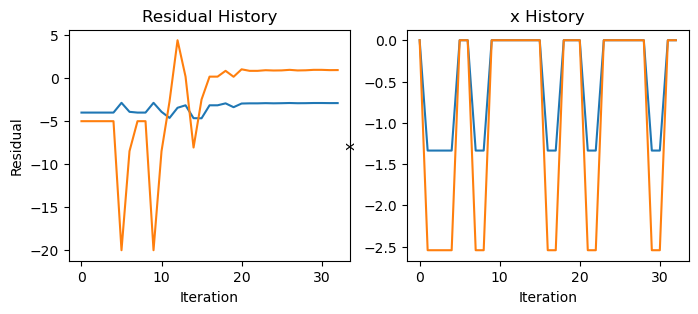

In [9]:
# plot the residual history and `x` history in two figures, side by side

import matplotlib.pyplot as plt
import seaborn as sns


def plot_history(residual_history, x_history):
    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    plt.plot(residual_history)
    plt.xlabel('Iteration')
    plt.ylabel('Residual')
    plt.title('Residual History')
    plt.subplot(1, 2, 2)
    plt.plot(x_history)
    plt.xlabel('Iteration')
    plt.ylabel('x')
    plt.title('x History')


plot_history(residual_history, x_history)

You can tell that the residual does not converge to zero, and the `x` are
jumping back and forth.

Now let's check the residual and `x` using initial guess `[1, 1]`.



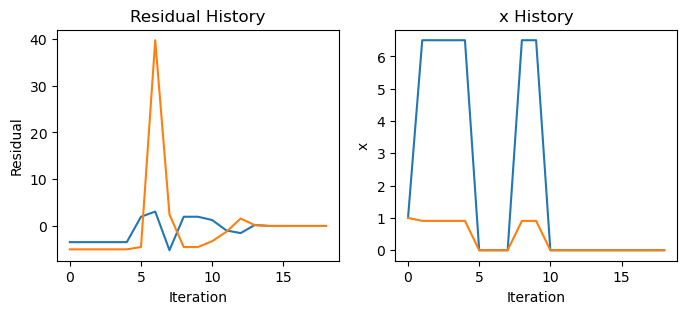

In [10]:
# don't forget to reset the history
residual_history = []
x_history = []

sol = fsolve(residual_with_history, [1, 1])
plot_history(residual_history, x_history)

#### More on Decorators

Decorators can be reused to wrap different functions. Suppose we have a
different residual function for which the history is needed. In addition to
writing out the residual function, we can use `@with_history` to wrap it. This
is a syntax sugar provided by Python.

```python
@with_history
def residual2(x):
    return [x[0]**2 + x[1]**2 - 1,
            x[0] + x[1] - 1]
```

### Convergence

We talked about "convergence", but what does it mean? Intuitively, it means that
the solution does not change much between iterations. That can be seen from the
previous figure. 

Typically, convergence is checked on the variable between consecutive
iterations. For a specified `xtol`, if the solution satisfies $|x_{k+1} - x_k| <
\text{xtol}$, the solution is deemed converged. This is what is checked by
`fsolve`.

In addition, the residual should be small enough when converged. The tolerance
is often named `ftol`. If the residual satisfies $|f(x_{k+1})| < \text{ftol}$, the solution
is deemed converged.

It is beneficial to check both of them if you are writing a custom solver.

## Jacobian Matrix

SciPy's `fsolve` uses the [Powell's hybrid
method](https://en.wikipedia.org/wiki/Powell%27s_dog_leg_method), which combines
the Newton-Raphson method with gradient descent. They require the Jacobian
matrix, which is the first-order derivatives of the residual function w.r.t the
unknown variables.

Calculating the Jacobian matrix is computationally expensive. By default,
`fsolve` uses the `hybrd` method in MINPACK, which calculates the Jacobian
matrix using finite differences. For each column of the Jacobian matrix, two
evaluations of the residual functions are needed, resulting in a total of `2N`
residual evaluations for an N-dimensional problem.

Providing the Jacobian matrix can speed up the calculation. This is one of the
reasons why texts on power system analysis always show Jacobian matrix. 

`fsolve` allows specifying the function that provides the Jacobian matrix
through the `fprime` argument.

To clarify, the Jacobian function is the first-order derivatives of the
**residual function** w.r.t the unknown variables. It is not necessarily the
derivative of the **original function** w.r.t the unknown variables.

In this case, the residual function is:

$$
r_0 = 
\begin{bmatrix}
x_0 \cos(x_1) - 4 \\
x_0 x_1 - x_1 - 5
\end{bmatrix}
$$

And the unkonwns are

$$
x = \begin{bmatrix}
x_0 \\
x_1
\end{bmatrix}
$$

Therefore, the **analytical** Jacobian matrix is:

$$
J = \begin{bmatrix}
\frac{\partial r_0}{\partial x_0} & \frac{\partial r_0}{\partial x_1} \\
\frac{\partial r_1}{\partial x_0} & \frac{\partial r_1}{\partial x_1}
\end{bmatrix} = 
\begin{bmatrix}
\cos(x_1) & -x_0 \sin(x_1) \\
x_1 & x_0 - 1
\end{bmatrix}
$$

It is called the analytical Jacobian matrix because it is derived based on
calculus. 


In [11]:
def jacobian(x):
    return [[np.cos(x[1]), -x[0]*np.sin(x[1])],
            [x[1], x[0] - 1]]


sol = fsolve(residual, x0, fprime=jacobian)
print(sol)

np.isclose(residual(sol), [0.0, 0.0])  # the residual at the solution should be almost 0.0.


[6.50409711 0.90841421]


array([ True,  True])

In this small example, we cannot see the performance gain from providing the
Jacobian matrix. However, this will be illustrated by a power flow problem.

## Power Flow Problem

A typical nonlinear equation is the power flow equations. Power flow equations are algebraic equations encorcing the power balancing at each bus. Intuitively, the equations require that, at each bus, the power injection (generation minus load) is equal to the power that leaves the bus through connected lines. 

Using the complex power definition, the power flow equations are as simple as:

$$
\begin{bmatrix}
P_1 + j Q_1 \\
P_2 + j Q_2 \\
\vdots \\
P_N + j Q_N
\end{bmatrix} = 
\text{diag}(V) (I)^*
=
\text{diag}(V) (Y V)^*
$$
where $P_i$ and $Q_i$ are the real and reactive power injection at bus $i$, $V_i$ and $V_j$ are the voltage at bus $i$ and $j$, $Y$ is the admittance matrix, an

$$
\text{diag}(V) = 
\begin{bmatrix}
V_1 & 0 & 0 & \cdots & 0 \\
0 & V_2 & 0 & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & \cdots & V_N
\end{bmatrix}
$$




If bus `k` has no injection, the corresponding $P_k$ and $Q_k$ are zero.



For a system with $N$ buses, there are $2N$ real-valued equations. There has to be $2N$ unkonwns to solve the equations. 

As we have learned from power system analysis, there are three types of buses, PQ, PV and Slack. The unknowns are:


| Bus Type | Knowns | Unknowns |
| -------- | -------- | -------- |
| PQ | $P_i, Q_i$ | $V_i, \theta_i$ |
| PV | $P_i, V_i$ | $Q_i, \theta_i$ |
| Slack | $V_i, \theta_i$ | $P_i, Q_i$ |



#### Example: 3-bus System

We consider a three-bus system from {cite:p}`crow2016computational` (Example 3.11). I have taken the liberty to use a 0-based index to align with Python code.

It is a three bus sytem with the following bus parameters:

| Bus | Type | V | Pgen | Qgen | Pload | Qload |
| ---- | -------- | -------- | -------- | -------- | -------- | -------- |
| 0 | Slack | 1.02 | -- | -- | 0.0 | 0.0 |
| 1 | PV | 1.00 | 0.5 | -- | 0.0 | 0.0 |
| 2 | PQ | -- | 0 | 0 | 1.2 | 0.5 |

And the line parameters are given as

| From | To | R | X | B |
| ---- | -------- | -------- | -------- | -------- |
| 0 | 1 | 0.02 | 0.3 | 0.15 |
| 0 | 2 | 0.01 | 0.1 | 0.1 |
| 1 | 2 | 0.01 | 0.1 | 0.1 |



First, let's make the admittance matrix.


In [12]:
Y = np.zeros((3, 3), dtype=np.complex128)

# Diagonal elements
Y[0, 0] = 1 / (0.02 + 0.3j) + 1 / (0.01 + 0.1j) + 1j * 0.15 / 2 + 1j * 0.1 / 2
Y[1, 1] = 1 / (0.02 + 0.3j) + 1 / (0.01 + 0.1j) + 1j * 0.15 / 2 + 1j * 0.1 / 2
Y[2, 2] = 1 / (0.01 + 0.1j) + 1 / (0.01 + 0.1j) + 1j * 0.1 / 2 + 1j * 0.1 / 2

# Off-diagonal elements
Y[0, 1] -= 1 / (0.02 + 0.3j)
Y[1, 0] -= 1 / (0.02 + 0.3j)

Y[0, 2] -= 1 / (0.01 + 0.1j)
Y[2, 0] -= 1 / (0.01 + 0.1j)

Y[1, 2] -= 1 / (0.01 + 0.1j)
Y[2, 1] -= 1 / (0.01 + 0.1j)

print(Y)

[[ 1.21133795-13.09457417j -0.22123894 +3.31858407j
  -0.99009901 +9.9009901j ]
 [-0.22123894 +3.31858407j  1.21133795-13.09457417j
  -0.99009901 +9.9009901j ]
 [-0.99009901 +9.9009901j  -0.99009901 +9.9009901j
   1.98019802-19.7019802j ]]


We can verify that the result matches the textbook:

In [13]:
# print Y in a polar form (using degrees)
print("Y magnitudes:")
print(np.abs(Y))

print("Y angles:")
print(np.angle(Y, deg=True))


Y magnitudes:
[[13.15048335  3.32595053  9.9503719 ]
 [ 3.32595053 13.15048335  9.9503719 ]
 [ 9.9503719   9.9503719  19.80124259]]
Y angles:
[[-84.71478916  93.81407483  95.71059314]
 [ 93.81407483 -84.71478916  95.71059314]
 [ 95.71059314  95.71059314 -84.26061502]]


We can move on and write the power flow equations. To conform with the standard form of `f(x) = 0`, the power injections are subtracted from both sides.

TODO: briefly explain the signs

In [24]:
def pf_3bus(x):
    
    # we can make the unknowns to be 
    #   x = [P0, Q0, theta1, Q1, theta2, V2]
    #   where theta is in radians and V is in per unit

    V = np.array([1.02, 1.00, x[5]])
    theta = np.array([0.0, x[2], x[4]])
    Vc = V * np.exp(1j * theta)

    # calculate the power injection into the network
    #   note that power leaves the bus into the network
    S = np.diag(Vc) @ np.conj(Y @ Vc)

    # power leaving each bus via the lines 
    #   minus power injection at each bus shall equal to 0
    P = np.real(S) - np.array([x[0], 0.5, -1.2])
    Q = np.imag(S) - np.array([x[1], x[3], -0.5])

    return np.concatenate([P, Q])


initial_guess = [0, 0, 0, 0, 0, 1.0]
sol, infodict, ier, mesg = fsolve(pf_3bus, initial_guess, full_output=True)

print(sol)

[ 0.70867913  0.28056964 -0.01009172 -0.04462179 -0.06351473  0.98158465]


This result is exactly the same as the one in the textbook.

#### Notes on the formulation

If you still have some impressions from the Power System Analysis course, you
may remember the lengthy derivations of the power flow equations and its
Jacobian matrix. In fact, this formulation comes much simpler than the textbook
ones, so it can be interesting to understand why both formulations work.

You may also have many questions about the formulation, such as

- Why is the P&Q at a slack bus and the Q at a PV bus included as variables,
  resulting in six variables for three buses?
- Following up on the previous question, why do we include two equations at the
  slack bus and one reactive power equation at the PV bus?
- Why are the variables not ordered in the typical way, namely, unknown phase
  angles and then unknown voltage magnitudes, yet it solves?
- Following up on the previous question, why is that ordering the convention (as
  written in textbooks and implemented in many programs)? Is that still relevant?


  These are left as exercises.


### Issues with previous implementation



## Custom Solver

## SymPy

In [ ]:
TODO

## References

```{bibliography}
:style: unsrt
:filter: docname in docnames
```